In [167]:
# Execute if necessary
# %%capture
# !pip install numpy seaborn matplotlib pandas openml

In [168]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, Tuple, Union, List
import openml
import sklearn
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

# Práctica 4: Overfitting

__Instrucciones__: A continuación hay una lista de funciones que debe implementar o tareas que debe desarrollar. La descripción de cada una de ellas se encuentra en la definición de cada una de las funciones. Cada función está marcada por &#x1F625;,  &#x1F643; o &#x1F921;. Las marcas indican:

- &#x1F625;: Indican una entrega que debe ser hecha dentro de la misma sesión de la asignación. 
- &#x1F643;: Indican una entrega que puede ser hecha hasta la siguiente sesión.
- &#x1F921;: Debe mostrar un avance en la misma sesión, pero la entrega puede ser hecha en la siguiente.

Aquellas entregas parciales que no sean hechas el día de la asignación ya no serán válidas para las entregas totales, sin embargo, las entregas totales seguirán siendo válidas.

En esta sección se incluye un dataset real. El dataset importado se llama LDPA y puede leer su descripción en la siguiente liga

https://www.openml.org/d/1483

In [169]:
# Descarga la metadata del dataset
dataset_info = openml.datasets.get_dataset(1483, download_data=False)

# Obtiene el nombre de la columna a predecir
target = dataset_info.default_target_attribute

(
    features, # Dataframe con las características que se pueden utilizar para predecir
    outputs, # Columna a predecir
    categorical_mask, # Máscara que indica que columnas de todas las características son categoricas
    columns # Lista con el nombre de las características
)= dataset_info.get_data(
    dataset_format="dataframe", target=target
)

categorical_mask = np.array(categorical_mask)
columns = np.array(columns)

In [170]:
print(f"La columna a predecir se llama '{target}'")
print(f"Todas las características son {str(columns)}")
print(f"Las características categóricas son {str(columns[categorical_mask])}")
print(f"Las características numéricas son {str(columns[~categorical_mask])}")

La columna a predecir se llama 'Class'
Todas las características son ['V1' 'V2' 'V3' 'V4' 'V5' 'V6' 'V7']
Las características categóricas son ['V1' 'V2']
Las características numéricas son ['V3' 'V4' 'V5' 'V6' 'V7']


In [171]:
# Impresión de las características
features

,V1,V2,V3,V4,V5,V6,V7
0,1,1,105794.0,105777.0,148933.0,108479.0,109365.0
1,1,4,105795.0,105778.0,155325.0,96952.0,161363.0
2,1,3,105796.0,105779.0,156652.0,101610.0,148870.0
3,1,1,105797.0,105780.0,149736.0,107135.0,102479.0
4,1,2,105798.0,105781.0,155978.0,125455.0,106203.0
...,...,...,...,...,...,...,...
164855,5,2,43687.0,43679.0,106611.0,123166.0,12432.0
164856,5,1,43688.0,43680.0,120821.0,119848.0,87463.0
164857,5,4,43689.0,43681.0,104999.0,110823.0,161536.0
164858,5,2,43690.0,43682.0,102191.0,112520.0,10811.0


In [172]:
outputs

0         3
1         3
2         3
3         3
4         3
         ..
164855    3
164856    3
164857    3
164858    3
164859    3
Name: Class, Length: 164860, dtype: category
Categories (11, object): ['1' < '2' < '3' < '4' ... '8' < '9' < '10' < '11']

A continuación se realiza la partición de __train__ y __test__. __No debe utilizar la partición de test por ningún motivo__.

In [173]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    features, 
    outputs, 
    test_size=0.5, 
    random_state=11
)

## Asignación 1 &#x1F921;

Utilizando las técnicas vistas en clase, realicé su mejor esfuerzo para obtener el mejor modelo lineal posible utilizando __únicamente el conjunto de entrenamiento__ (X_train y y_train). Puede utilizar bibliotecas, pero únicamente las técnicas vistas en clase y debe ir generando métricas o visualizaciones que respalden su toma de decisiones. Debe tener e imprimir una estimación de $E_{out}$ utilizando su conjunto de entrenamiento. La métrica utilizada será la entropía cruzada.

- **V1** = {A, B, C, D, E} = 5 people
- **V2** = {ANKLE_LEFT, ANKLE_RIGHT, CHEST, BELT}
- **V3** = timestamp (Numeric) all unique
- **V4** = date FORMAT (Date)
- **V5** = x coordinate of the tag (Numeric)
- **V6** = y coordinate of the tag (Numeric)
- **V7** = z coordinate of the tag (Numeric)
- **output** = activity = {'walking', 'falling', 'lying down', 'lying', 'sitting down', 'sitting', 'standing up from lying', 'on all fours', 'sitting on the ground', 'standing up from sitting', 'standing up from sitting on the ground'} (Nominal)

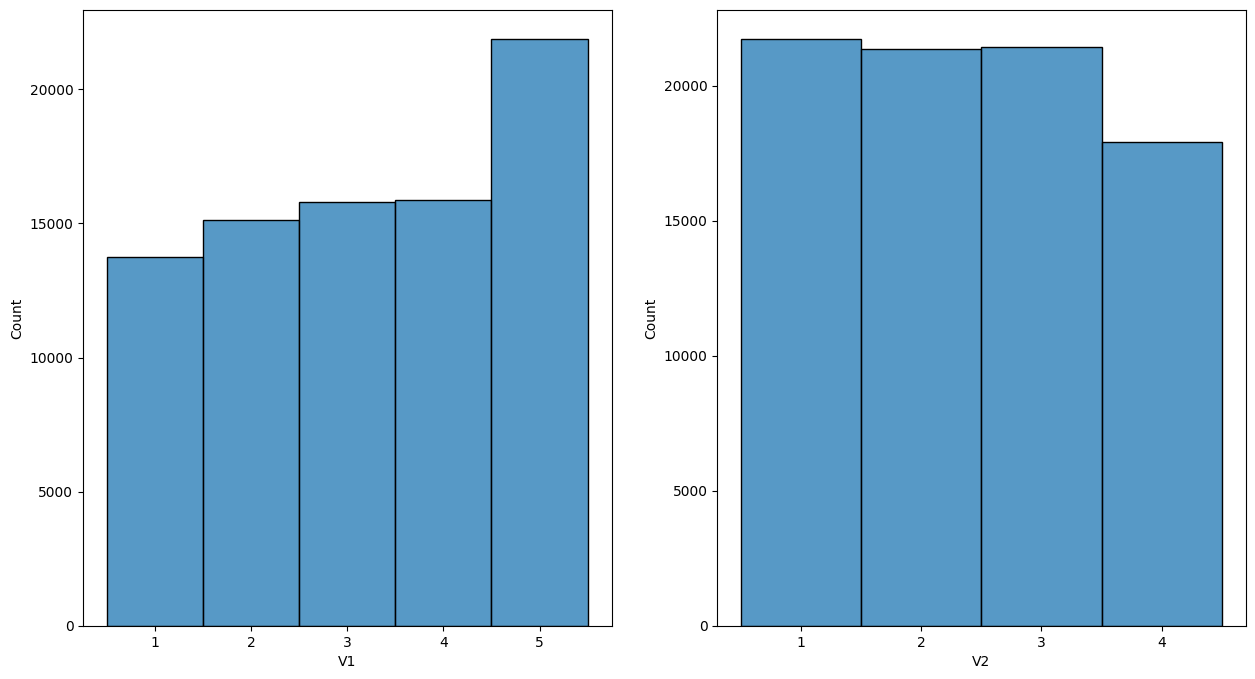

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns

columns = ["V1", "V2"]
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 8))


axs = [ax for ax in axs.flat]
for i, col in enumerate(columns):
    sns.histplot(data=X_train, x=col, ax=axs[i])


<AxesSubplot: xlabel='Class', ylabel='Count'>

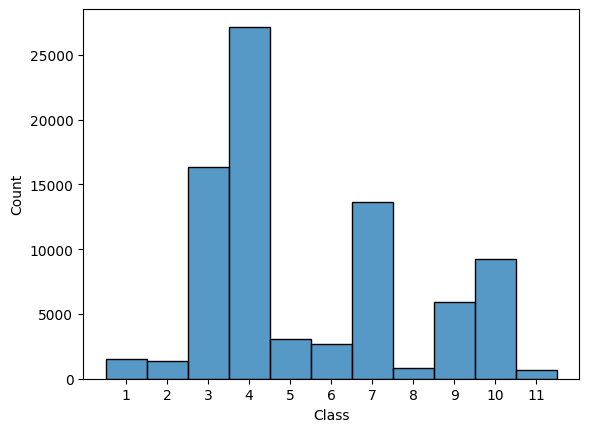

In [175]:
sns.histplot(x = y_train)

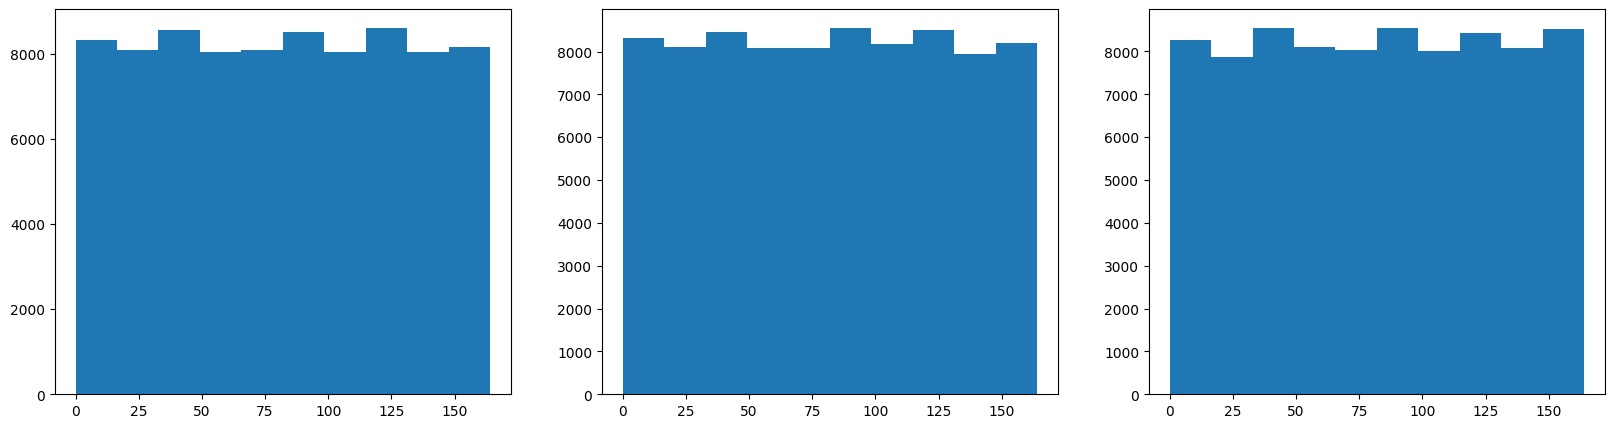

In [176]:
columns = ["V5", "V6", "V7"]
fig, axs = plt.subplots(ncols=3, nrows= 1, figsize = (20,5))

for i, col in enumerate(columns):
    new_val = X_train[col].values
    new_val = new_val*(1/1000)
    X_train[col] = np.round(new_val)
    axs[i].hist(x = new_val.round())

In [177]:
# Hacemos One Hot Encoding para V2 y V1
X_train = pd.get_dummies(X_train, prefix=["V2","V1"], columns=["V2","V1"])
X_train

,V3,V4,V5,V6,V7,V2_1,V2_2,V2_3,V2_4,V1_1,V1_2,V1_3,V1_4,V1_5
82677,158321.0,158297.0,72.0,106.0,146.0,0,0,1,0,0,0,1,0,0
2843,108637.0,108619.0,135.0,76.0,79.0,1,0,0,0,1,0,0,0,0
50670,98841.0,98825.0,76.0,137.0,102.0,0,1,0,0,0,1,0,0,0
128441,7274.0,7273.0,97.0,128.0,138.0,0,0,0,1,0,0,0,0,1
10592,116386.0,116368.0,70.0,141.0,119.0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102327,56803.0,56792.0,146.0,115.0,48.0,0,1,0,0,0,0,0,1,0
97617,52093.0,52085.0,55.0,81.0,27.0,0,1,0,0,0,0,0,1,0
21584,127378.0,127358.0,45.0,105.0,49.0,1,0,0,0,1,0,0,0,0
36543,84714.0,84700.0,59.0,33.0,114.0,0,1,0,0,0,1,0,0,0


<AxesSubplot: xlabel='Class', ylabel='Count'>

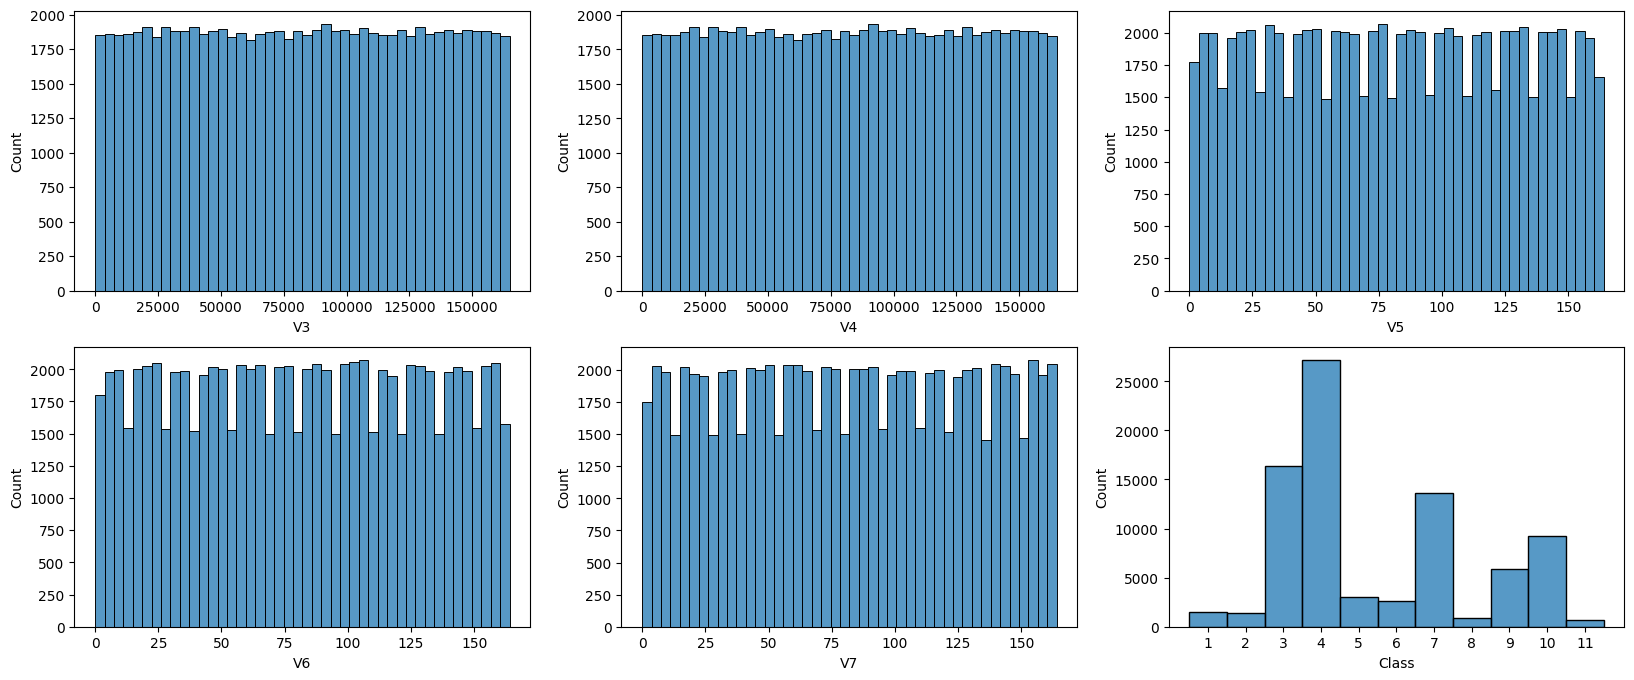

In [178]:
columns = ["V3", "V4", "V5", "V6", "V7"]
fig, axs = plt.subplots(ncols=3, nrows= 2, figsize=(20, 8))

for i, col in enumerate(columns):
    sns.histplot(data = X_train, x = col, ax = axs[i // 3, i % 3])

sns.histplot(x = y_train, ax = axs[1, 2])

In [179]:
corr_x = X_train.corr()
print(corr_x.abs().unstack().drop_duplicates().sort_values(ascending=False))

V3    V3      1.000000
      V4      1.000000
      V1_5    0.764943
V4    V1_5    0.764936
      V1_3    0.681512
                ...   
V3    V2_2    0.004961
V5    V2_3    0.004053
      V2_2    0.003854
V2_2  V1_2    0.003547
V2_3  V1_2    0.001791
Length: 92, dtype: float64


In [180]:
print(corr_x["V3"].mean())
print(corr_x["V4"].mean())
corr_x = X_train.drop(columns=['V3']).corr()
print(corr_x["V4"].mean())
print(corr_x["V1_5"].mean())

0.1450197496482575
0.14501973800835072
0.0792520255716538
-0.061273435604749585


In [181]:
X_train = X_train.drop(columns=['V3', 'V4'])
X_train

,V5,V6,V7,V2_1,V2_2,V2_3,V2_4,V1_1,V1_2,V1_3,V1_4,V1_5
82677,72.0,106.0,146.0,0,0,1,0,0,0,1,0,0
2843,135.0,76.0,79.0,1,0,0,0,1,0,0,0,0
50670,76.0,137.0,102.0,0,1,0,0,0,1,0,0,0
128441,97.0,128.0,138.0,0,0,0,1,0,0,0,0,1
10592,70.0,141.0,119.0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
102327,146.0,115.0,48.0,0,1,0,0,0,0,0,1,0
97617,55.0,81.0,27.0,0,1,0,0,0,0,0,1,0
21584,45.0,105.0,49.0,1,0,0,0,1,0,0,0,0
36543,59.0,33.0,114.0,0,1,0,0,0,1,0,0,0


In [182]:
pca = PCA(n_components=3)

# data scaling
x_scaled = StandardScaler().fit_transform(features) 

pca_features = pca.fit_transform(x_scaled)
 
print('Forma  andes de calcular PCA: ', x_scaled.shape)
print('Forma  antes de calcular PCA: ', pca_features.shape)
 
pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2', 'PC3'])
pca_df['target'] = outputs

pca_df

Forma  andes de calcular PCA:  (164860, 7)
Forma  antes de calcular PCA:  (164860, 3)


,PC1,PC2,PC3,target
0,-1.225172,-0.665749,0.708134,3
1,-1.454080,2.022142,1.025052,3
2,-1.377273,1.194982,0.962786,3
3,-1.216914,-0.768396,0.734172,3
4,-1.261877,-0.076741,0.556019,3
...,...,...,...,...
164855,1.789397,-1.201160,-0.394494,3
164856,1.786374,-0.743463,-0.068428,3
164857,1.498467,2.289668,-0.099546,3
164858,1.779380,-1.221777,-0.301680,3


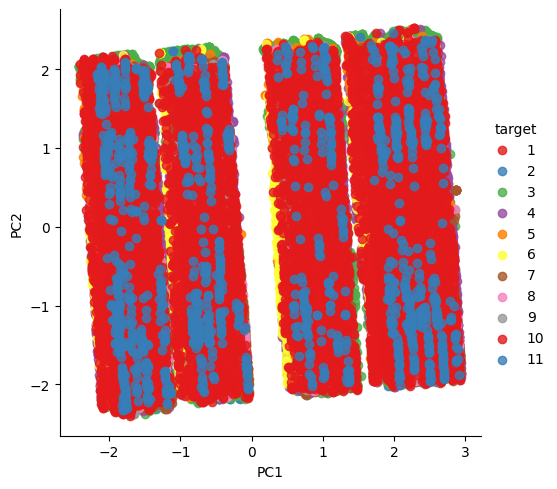

In [183]:
sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=pca_df, 
    hue='target', 
    fit_reg=False, 
    legend=True,
    palette='Set1'
    )

In [184]:
model_LR = make_pipeline(MinMaxScaler(), LogisticRegression(solver="sag", multi_class='multinomial'))
scores_LR = cross_val_score(model_LR, pca_df[["PC1", "PC2", "PC3"]], pca_df["target"], cv=16)
print("%0.5f Precision con una  deviacion estandar de %0.5f" % (scores_LR.mean(), scores_LR.std()))

0.32401 Precision con una  deviacion estandar de 0.02822


In [185]:
model_LR = make_pipeline(MinMaxScaler(), LogisticRegression(solver="sag", multi_class='multinomial'))
scores_LR = cross_val_score(model_LR, X_train, y_train, cv=16)
print("%0.5f Precicion con una desviacion estandar de  %0.5f" % (scores_LR.mean(), scores_LR.std()))

0.39352 Precicion con una desviacion estandar de  0.00576


In [186]:
model_SGD = make_pipeline(StandardScaler(), SGDClassifier(loss='log_loss', penalty='l1'))
scores_SGD = cross_val_score(model_SGD, X_train, y_train, cv=16)
print("%0.4f Precicion con una desviacion estandar  de %0.4f" % (scores_SGD.mean(), scores_SGD.std()))

0.3792 Precicion con una desviacion estandar  de 0.0093


In [187]:
model_SGD = make_pipeline(StandardScaler(), SGDClassifier(loss='perceptron', penalty='l1'))
scores_SGD = cross_val_score(model_SGD, X_train, y_train, cv=16)
print("%0.5f Precicion con una desviacion estandar  de %0.5f" % (scores_SGD.mean(), scores_SGD.std()))

0.21987 Precicion con una desviacion estandar  de 0.03826


In [188]:
model = make_pipeline(MinMaxScaler(), LogisticRegression(solver="sag", multi_class='multinomial'))
model = model.fit(X_train, y_train)

print("Tenemos una precision de %0.5f " % model.score(X_train, y_train))

Tenemos una precision de 0.39367 


In [189]:
def scaled_dataframe(data):
    data_scaled = data
    for i in data.columns:
        if data[i].dtype == 'int64' or data[i].dtype == 'float64':
            min_r = np.amin(data[i])
            max_r = np.amax(data[i])

            data_scaled[i] = (data[i]-min_r)/(max_r-min_r)

    return data_scaled

In [190]:
X_train = scaled_dataframe(X_train)
model = LogisticRegression(solver="sag", multi_class='multinomial')
model = model.fit(X_train, y_train)

print("Tenemos una precision de %0.5f" % model.score(X_train, y_train))

Tenemos una precision de 0.39361


## Asignación 2 &#x1F921;

Evalue su modelo final en el conjunto de test (X_test y y_test). Su práctica será evaluada acorde a las técnicas aplicadas, la estimación de $E_{out}$, el valor de $E_{test}$, y contra las métricas obtenidas por sus compañeros.

In [191]:
X_test = pd.get_dummies(X_test, prefix=["V1","V2"], columns=["V1","V2"])
X_test = X_test.drop(columns=['V3', 'V4'])

X_test = scaled_dataframe(X_test)
X_test

,V5,V6,V7,V1_1,V1_2,V1_3,V1_4,V1_5,V2_1,V2_2,V2_3,V2_4
9783,0.551893,0.110488,0.740631,1,0,0,0,0,0,0,0,1
85013,0.034487,0.904584,0.394811,0,0,1,0,0,0,0,0,1
70883,0.166508,0.616167,0.702954,0,0,1,0,0,1,0,0,0
64466,0.108150,0.390706,0.068819,0,0,1,0,0,0,1,0,0
82448,0.002424,0.988728,0.997082,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
102897,0.396319,0.337793,0.418006,0,0,0,1,0,1,0,0,0
40732,0.209603,0.193985,0.438459,0,1,0,0,0,0,1,0,0
114945,0.144371,0.230592,0.814192,0,0,0,1,0,0,0,1,0
19389,0.751392,0.110091,0.546481,1,0,0,0,0,0,1,0,0


In [192]:
y_pred = model.predict(X_test)
fig, axs = plt.subplots(ncols=2, nrows= 1, figsize=(12, 8))
sns.histplot(x = y_test, ax = axs[0])
sns.histplot(x = y_pred, ax = axs[1])

ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


In [ ]:
model.score(X_test, y_test)

0.39451655950503456